# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns

%matplotlib inline

# Instatiate a grid from a DEM raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [2]:
grid = Grid.from_raster('../data/n30w100_con',
                        data_name='dem', input_type='ascii')

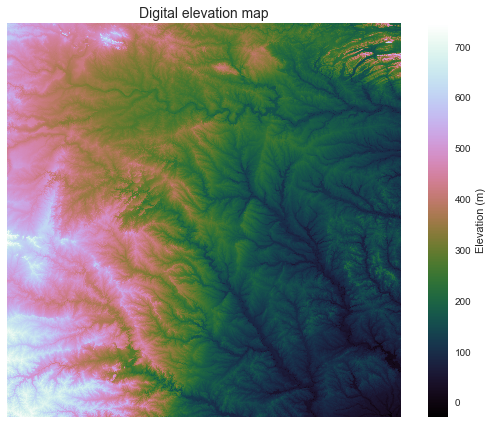

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig('conditioned_dem.png', bbox_inches='tight')

# Read a flow direction grid from a raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [4]:
grid.read_raster('../data/n30w100_dir',
                 data_name='dir', input_type='ascii')

# Examine grid

In [5]:
grid.dir

array([[ 64,  64,  64, ...,   1,   2, 128],
       [ 32,  64,  64, ...,   1,   1, 128],
       [ 32,  32,  32, ...,   1, 128,  64],
       ...,
       [128,  64,  64, ...,  16,   8,   4],
       [128,  64,  64, ...,   4,  16,   4],
       [  8,  64,  64, ...,   8,   4,   4]], dtype=uint8)

In [6]:
grid.dir.size

36000000

# Specify flow direction values

In [7]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Examine grid

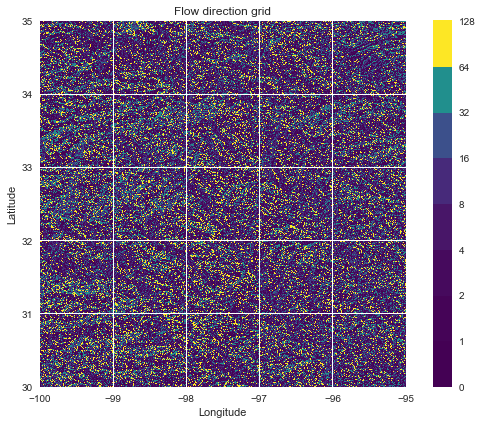

In [8]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='viridis')
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.tight_layout()
plt.savefig('flow_direction.png', bbox_inches='tight')

# Delineate catchment

In [9]:
# Specify pour point
x, y = -97.2937, 32.7371

# Delineate the catchment
grid.catchment(x, y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

In [10]:
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

Unalignable bbox provided, rounding to [-97.4025      32.60666667 -97.26166667  32.73916667]


In [12]:
# Get a view of the catchment
catch = grid.view('catch')

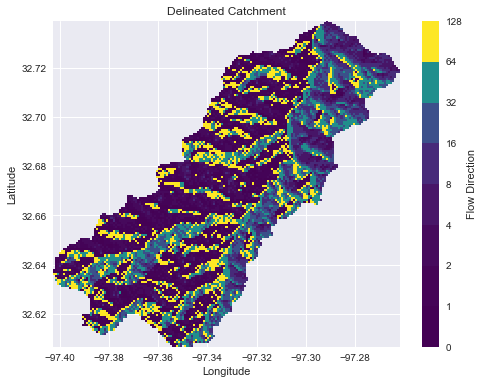

In [12]:
# Plot the catchment
image_arr = np.where(catch, catch, np.nan)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(image_arr, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), label='Flow Direction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment')
plt.savefig('catchment.png', bbox_inches='tight')

# Get flow accumulation

In [13]:
grid.accumulation(catch, dirmap=dirmap, pad_inplace=False, out_name='acc')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


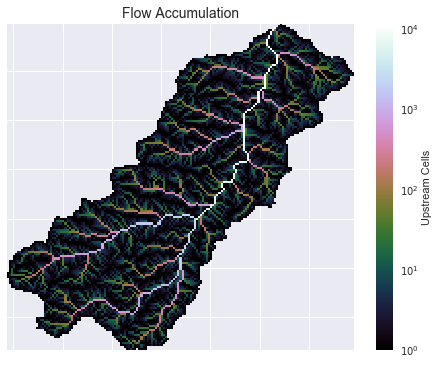

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.title('Flow Accumulation', size=14)
plt.savefig('flow_accumulation.png', bbox_inches='tight')

# Get distances to upstream cells

In [15]:
pour_point_y, pour_point_x = np.unravel_index(np.argmax(grid.view('catch')), grid.shape)

In [16]:
grid.flow_distance(pour_point_x, pour_point_y, dirmap=dirmap, out_name='dist')

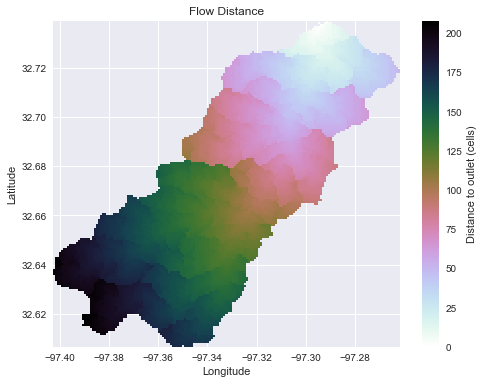

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance')
plt.savefig('flow_distance.png', bbox_inches='tight')